# Utilizar a base de dados normalizados para treinar um modelo de regressão logistica utilizando o sklearn.

## Definição de pronto

### Normalizador desenvolvido no ambiente

## Definição de entregue

### Notebook fazendo a avaliação

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pd.set_option("display.precision", 2)

feature_norm  = True

target_variable = ['quality']

classifier_variables = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                      'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                      'pH', 'sulphates', 'alcohol', 'type', ]

### Carregando a base processada

In [13]:
df_wine = pd.read_parquet("../../Data/Processed/wine/df_wine.parquet")
print(df_wine.shape)
print(df_wine.columns)
df_wine.head()

(6497, 13)
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'type'],
      dtype='object')


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
index,,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.08,11.0,34.0,1.0,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.10,25.0,67.0,1.0,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.09,15.0,54.0,1.0,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.07,17.0,60.0,1.0,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.08,11.0,34.0,1.0,3.51,0.56,9.4,5,1


### Selecionando os dados que serao utilizados


### Normalizando os dados

In [14]:
df_wine[classifier_variables] = preprocessing.power_transform(df_wine[classifier_variables], method='yeo-johnson')

/home/marcelo/Documentos/infnet/conda/conda_env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


#### Problema reportado no método yeo-johnson

https://github.com/scikit-learn/scikit-learn/issues/14959

### Ajuste dos dados para o treinamento

In [15]:
# Configurando o Pipeline
conf_train_pipe = [
    ('Scaler', StandardScaler()),
    ('Model', LogisticRegression(random_state=0)),
]

# Criando o Pipeline
model_pipe = pipeline.Pipeline(conf_train_pipe)

# Train Pipeline
X = df_wine[classifier_variables].values
Y = df_wine[target_variable].values
idx = Y > 5
classes=['baixa qualidade','alta qualidade']
Y[idx] = 1
Y[~idx]= 0

model_pipe.fit(X, Y)

/home/marcelo/Documentos/infnet/conda/conda_env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Pipeline(steps=[('Scaler', StandardScaler()),
                ('Model', LogisticRegression(random_state=0))])

### Estimativa dos modelos treinados

In [16]:
Yhat = model_pipe.predict_proba(X)[:,1]
Ypred= model_pipe.predict(X)
print('Yhat.shape:', Yhat.shape)
print('Ypred.shape:', Ypred.shape)

Yhat.shape: (6497,)
Ypred.shape: (6497,)


### Distribuição das estimativas do modelo utilizando o seaborn

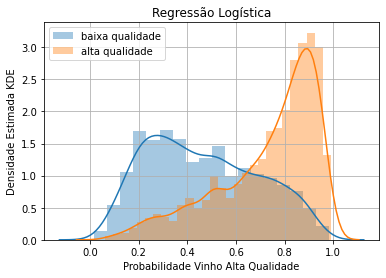

In [17]:
for i in range(len(classes)):
    # 2 Classes case
    sns.distplot(Yhat[Y[:,0] == i], label=classes[i])

plt.title('Regressão Logística')
plt.ylabel('Densidade Estimada KDE')
plt.xlabel('Probabilidade Vinho Alta Qualidade')
plt.grid()
plt.legend()

Text(0, 0.5, 'Taxa de Detecção')

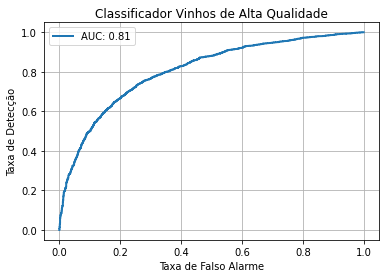

In [18]:
# help(metrics.roc_curve)
plt.figure()
fpr, tpr, thr = metrics.roc_curve(Y, Yhat)
auc = metrics.roc_auc_score(Y, Yhat)
plt.plot(fpr, tpr, '-', lw=2, label='AUC: %.2f'%(auc))
plt.legend()
plt.title('Classificador Vinhos de Alta Qualidade')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')

**Pela curva ROC poderíamos escolher uma taxa de detecção (sensibilidade) de aproximadamente 75% que teríamos  aproximadamente 20% de falsos positivos (especificidade).**

In [19]:
col_names = ['Modelo ' + s for s in classes]
idx_names = ['Real ' + s for s in classes]

cmat = metrics.confusion_matrix(Y, Ypred)
cmat = pandas.DataFrame(cmat, index=idx_names,
                              columns=col_names)
cmat['Real Total'] = cmat.sum(axis=1)
cmat.loc['Modelo Total',:] = cmat.sum(axis=0)
cmat = cmat.astype(int)
cmat

,Modelo baixa qualidade,Modelo alta qualidade,Real Total
Real baixa qualidade,1372,1012,2384
Real alta qualidade,638,3475,4113
Modelo Total,2010,4487,6497


In [10]:
print(metrics.classification_report(Y, Ypred, target_names=classes))

                 precision    recall  f1-score   support

baixa qualidade       0.68      0.57      0.62      2384
 alta qualidade       0.77      0.84      0.81      4113

       accuracy                           0.74      6497
      macro avg       0.73      0.71      0.71      6497
   weighted avg       0.74      0.74      0.74      6497



/home/marcelo/Documentos/infnet/conda/conda_env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


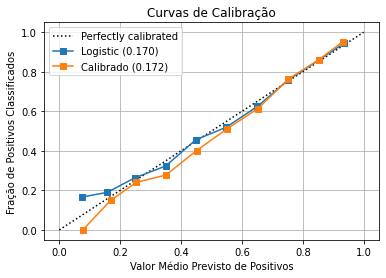

In [11]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Calibrated with sigmoid calibration
calib_sigmoid = CalibratedClassifierCV(model_pipe, cv=None, method='sigmoid')
calib_sigmoid.fit(X,Y)
Ypred_calib = calib_sigmoid.predict(X)
Yhat_calib  = calib_sigmoid.predict_proba(X)[:,1]


# Modelo perfeito
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Modelo logistico puro
clf_score = metrics.brier_score_loss(Y, Yhat, pos_label=1)
fraction_of_positives, mean_predicted_value = calibration_curve(Y, Yhat, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Logistic (%1.3f)" %clf_score)

# Modelo calibrado
clf_score = metrics.brier_score_loss(Y, Yhat_calib, pos_label=1)
fraction_of_positives, mean_predicted_value = calibration_curve(Y, Yhat_calib, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibrado (%1.3f)" %clf_score)

plt.ylabel("Fração de Positivos Classificados")
plt.xlabel("Valor Médio Previsto de Positivos")
plt.ylim([-0.05, 1.05])
plt.title('Curvas de Calibração')
plt.legend()
plt.grid()